In [0]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from IPython import display

torch.manual_seed(2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device: {}'.format(device))


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    
def get_params_num(net):
    return sum(map(torch.numel, net.parameters()))

    
def get_accuracy(dataloader, model, device='cpu'):
    tot = len(dataloader.dataset)
    with torch.no_grad():
        n_right = 0
        for data in dataloader:
            batch = data[0].to(device)
            labels = data[1].to(device)
            
            outputs = model(batch)
            out_labels = torch.argmax(outputs, dim=1)
            n_right += torch.sum(labels == out_labels)
    return float(n_right) / tot

Device: cuda:0


In [0]:
# import STL10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.STL10(root='./data', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.STL10(root='./data', split='test',
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

print("STL10 images shape: {}".format(tuple(trainset[0][0].shape)))


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified
CIFAR images shape: (3, 96, 96)


In [0]:

class Bottleneck(nn.Module):
    def __init__(self, in_channels, reduction_factor):
        super(Bottleneck, self).__init__()
        self.bottleneck = nn.Conv2d(in_channels,in_channels // reduction_factor, kernel_size=1)
        self.conv = nn.Conv2d(in_channels // reduction_factor, in_channels // reduction_factor, 
                              padding=1, kernel_size=3)
        self.expansion = nn.Conv2d(in_channels // reduction_factor, in_channels, kernel_size=1)
        self.act = nn.LeakyReLU()
        
    def forward(self, x):
        x = self.act(self.bottleneck(x))
        x = self.act(self.conv(x))
        x = self.expansion(x)
        return x
    

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, reduction_factor):
        super(ResidualBlock, self).__init__()
        self.bottleneck = Bottleneck(in_channels, reduction_factor)
        
    def forward(self, x):
        return x + self.bottleneck(x)
    
    
class GlobalAveragePooling(nn.Module):
    def forward(self, x):
        return torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
    
    
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        C = 256
        n_classes = 10
        
        
        self.network = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3),#30
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2),#15
                nn.Dropout(p=0.2),
                nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3),#13
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2,stride=1),#12
                nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3),#10
                nn.LeakyReLU(),
                nn.MaxPool2d(kernel_size=2),#5
                nn.Flatten(),
                nn.Linear(32*5*5, 100),
                nn.LeakyReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(100, n_classes),
        )
        
    def forward(self, x, verbose=False):
        return self.network(x)
        
        
net = CNN()
net.to(device)
print("# of parameters: {}".format(get_params_num(net)))
print(net)
net=torchvision.models.googlenet(pretrained=True, progress=True)

# of parameters: 176950
CNN(
  (network): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
    (8): LeakyReLU(negative_slope=0.01)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Flatten()
    (11): Linear(in_features=800, out_features=100, bias=True)
    (12): LeakyReLU(negative_slope=0.01)
    (13): Dropout(p=0.2, inplace=False)
    (14): Linear(in_features=100, out_features=10, bias=True)
  )
)


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


In [0]:
net.to(device)
lr = 0.001
epochs = 5

n_batches = len(trainloader)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.92)

net.train() 
for e in range(epochs):
    for i, data in enumerate(trainloader):
        batch = data[0].to(device)
        labels = data[1].to(device)      
        outputs = net(batch)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 50 == 0:
            print("[EPOCH]: {}, [BATCH]: {}/{}, [LOSS]: {}".format(e, i, n_batches, loss.item()))
            display.clear_output(wait=True)
    scheduler.step()

[EPOCH]: 4, [BATCH]: 150/157, [LOSS]: 0.11852310597896576


In [0]:
acc_train = get_accuracy(trainloader, net, device=device)
net.eval()
acc_test = get_accuracy(testloader, net, device=device)
print("Train accuracy: {}\nTest accuracy: {}".format(acc_train, acc_test))

Train accuracy: 0.9562
Test accuracy: 0.8185


In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
def test( model, device, test_loader, epsilon):

    # Accuracy counter
    correct = 0
    acc_init=0
    adv_examples = []
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        #print(target.item())

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = torch.argmax(output, dim=1) # get the index of the max log-probability
        #print(init_pred.item())
        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue
             

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = torch.argmax(output, dim=1) # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader)*acc_test)
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader)*acc_test, final_acc))
    #print(acc_init/float(len(test_loader)))
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [0]:
accuracies = []
examples = []
epsilons=[0,0.05,0.1,0.15,0.2]
# Run test for each epsilon
for eps in epsilons:
    print(eps)
    acc, ex = test(net, device, testloader, eps)
    accuracies.append(acc)
    examples.append(ex)

0
Epsilon: 0	Test Accuracy = 6548 / 6548.0 = 1.0
0.05
Epsilon: 0.05	Test Accuracy = 454 / 6548.0 = 0.0693341478313989
0.1
Epsilon: 0.1	Test Accuracy = 209 / 6548.0 = 0.031918142944410505
0.15
Epsilon: 0.15	Test Accuracy = 198 / 6548.0 = 0.030238240684178377
0.2
Epsilon: 0.2	Test Accuracy = 237 / 6548.0 = 0.03619425778863775


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

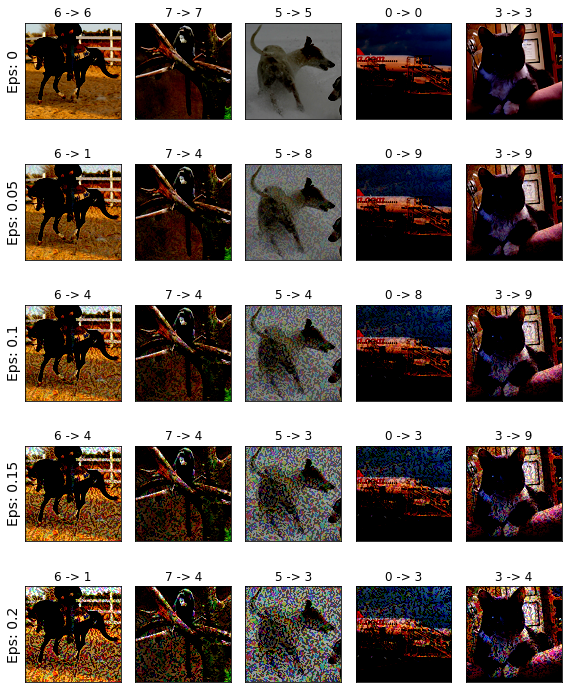

In [0]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        ex = np.transpose(ex, (1, 2, 0))
        plt.imshow(ex)
plt.tight_layout()
plt.show()